In [9]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline 

In [10]:
# import all pyphysio classes and methods
import pyphysio as ph

In [12]:
# import data and creating a signal
df_BVP = pd.read_csv('BVP_pp53.csv', header=None)

In [13]:
#counting n rows 
n_of_rows = df_BVP.count()
print(n_of_rows)

0    1048574
dtype: int64


In [14]:
#actual recording time 59 mins = 3540s
#rows based on seconds 
n_of_rows_keep = 3540*64
print(n_of_rows_keep) #rows we want to keep 

226560


In [17]:
#using pandas to drop all the rows / seconds after 3480s 
#[n_of_rows_keep:n_of_rows]
df_BVP = df_BVP.drop(df_BVP.index[226560:1048574])
print(df_BVP)

           0
0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
...      ...
753815  0.02
753816  0.12
753817  0.14
753818  0.10
753819  0.05

[226560 rows x 1 columns]


In [18]:
#count n of rows to get time of recording (s) 
n_of_rows = df_BVP.count()
print(n_of_rows)
#walk time in seconds 
walk_time_seconds = n_of_rows/64
print(walk_time_seconds)
#walk time in minutes
walk_time_minutes = walk_time_seconds/60
print(walk_time_minutes)

0    226560
dtype: int64
0    3540.0
dtype: float64
0    59.0
dtype: float64


In [19]:
#create BVP signal 
fsamp = 64  #64 Hz = 0.015625 s(p)
ecg = ph.EvenlySignal(values = df_BVP, sampling_freq = fsamp, signal_type = 'ecg')
tstart_df_BVP = 100 #s

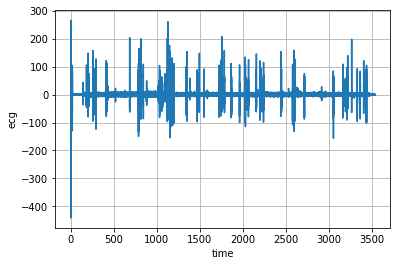

In [20]:
ecg.plot()

In [21]:
ibi = ph.BeatFromECG()(ecg)

In [22]:
ibi.get_duration() 

3540.0

In [23]:
# create label
label = np.zeros(3540)
label[0:600] = 1
label[600:3540] = 2

label = ph.EvenlySignal(label, sampling_freq = 1, signal_type = 'label') 
#sampling_freq here is not intended as real sampfeq, only the distance between one point and the other (e.g. 10 = 10 units between 'begin' & 'end')

In [24]:
# (optional) IIR filtering : remove high frequency noise
#ecg = ph.IIRFilter(fp=45, fs = 50, ftype='ellip')(ecg)

In [25]:
# normalization : normalize data
ecg = ph.Normalize(norm_method='standard')(ecg)

In [26]:
# resampling : increase the sampling frequency by cubic interpolation
ecg = ecg.resample(fout=4096, kind='cubic')
fsamp = 4096

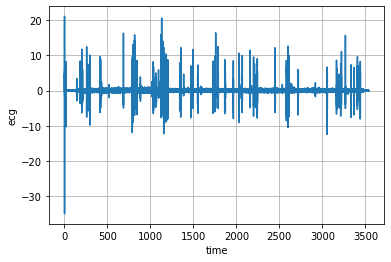

In [27]:
ecg.plot()

In [28]:
ibi = ph.BeatFromECG()(ecg)

In [29]:
ibi.get_duration()

3540.0

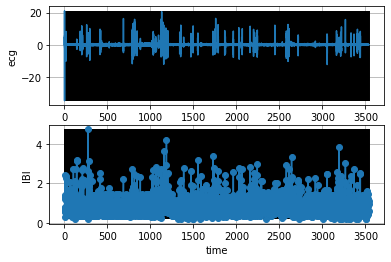

In [30]:
# check results so far
ax1 = plt.subplot(211)
ecg.plot()
plt.vlines(ibi.get_times(), np.min(ecg), np.max(ecg))

plt.subplot(212, sharex = ax1)
ibi.plot('o-')
plt.vlines(ibi.get_times(), np.min(ibi), np.max(ibi))
plt.show()

In [31]:
### physiological indicators 

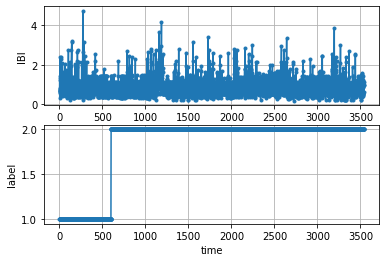

In [32]:
# check label
ax1 = plt.subplot(211)
ibi.plot('.-')

plt.subplot(212, sharex = ax1)
label.plot('.-')
plt.show()


In [33]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [34]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 60, width = 60, labels = label)

indicators, col_names = ph.fmap(fixed_length, hrv_indicators, ibi)

In [35]:
# extract column with the labels for each window
label_w = indicators[:, np.where(col_names == 'label')[0]]

# extract column with the RRmean values computed from each window
rrmean_w = indicators[:, np.where(col_names == 'RRmean')[0]]

rrmean_image1 = rrmean_w[np.where(label_w==1)[0]].ravel()
rrmean_image2 = rrmean_w[np.where(label_w==2)[0]].ravel()

{'whiskers': [<matplotlib.lines.Line2D at 0x1c1b5f7b50>,
 'caps': [<matplotlib.lines.Line2D at 0x1c1b5ea350>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c1b5f7b10>,
 'medians': [<matplotlib.lines.Line2D at 0x1c1b392bd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c1b602cd0>,
 'means': []}

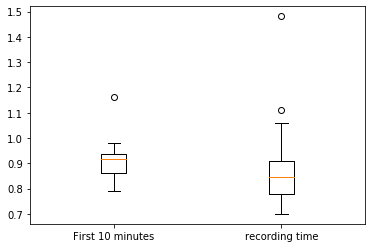

In [36]:
## create a box and whisker plot to compare the distibution of the RRmean indicator
plt.boxplot([rrmean_image1, rrmean_image2],
            labels=['First 10 minutes', 'recording time'])

In [38]:
HRV_FD = ph.preset_hrv_fd() #frequency domain HRV indicators
print(HRV_FD)

print(HRV_FD[0].get())

[IBI_VLF_Pow, IBI_LF_Pow, IBI_HF_Pow, IBI_Total_Pow]
{'freq_min': 1e-05, 'freq_max': 0.04, 'method': 'ar', 'interp_freq': 4, 'name': 'IBI_VLF_Pow'}


In [39]:
FD_HRV_ind, col_names = ph.fmap(fixed_length, ph.preset_hrv_fd(), ibi.resample(4))

In [40]:
import pandas as pd

# create a pandas dataframe
FD_HRV_pp53_df = pd.DataFrame(FD_HRV_ind, columns=col_names)

FD_HRV_pp53_df.head()

,begin,end,label,IBI_VLF_Pow,IBI_LF_Pow,IBI_HF_Pow,IBI_Total_Pow
0,1.228271,61.228271,1.0,161.139993,469.081862,725.610040,2096.379455
1,61.228271,121.228271,1.0,280.693318,518.407996,668.853292,2224.967950
2,121.228271,181.228271,1.0,687.722814,796.375914,671.610850,2861.416060
3,181.228271,241.228271,1.0,341.748504,769.127122,735.842325,2629.101477
4,241.228271,301.228271,1.0,306.741661,828.589962,704.266478,2518.109464


In [41]:
#save data
FD_HRV_pp53_df.to_csv('FD_HRV_pp53.csv')